# HW1 

Отчет

В данной домашней работе рассматривались наиболее простые и быстрые решения улучшения работы модели, которыми можно руководствоваться в случае, если улучшения нужно внедрять прямо здесь и сейчас (а лучше вчера). К такому файн тюнингу обращаются, если команда понимает, что исследование и разработка новой модели займет ощутимое время, а клиентов в сервисе нужно удержать и по возможности улучшить метрики самым быстрым способом. 

Самыми очевидными решениями в таком случае, являются:
   - улучшение существующих Contextual рекомендаций 
   - замена дефолтного рекоммендера, который срабатывает в случае когда мы не смогли найти рекомендацию или отсутствуют исторические данные о предпочтениях слушателя
   - внедрение фильтра для обработки уже прослушанных треков пользователем
   - дообучение модели еще чуть-чуть или получение большего набора предсказаний из существующей модели

    1) Contextual Top Range

Для улучшения скора Contxtual рекоммендера использовался список топ-треков. Треки Contextual рекомендаций ранжировались с учетом этого списка, пользователю включался рандомный трек из 50 наиболее популярных треков. Причем, как при увеличении топа до 70, так и при уменьшении до 30 треков замечалось ухудшение влияния данного подхода на статистики. Данный подход не оказал статистически значимого вляния на результат mean_time_per_session, однако был оставлен, так как предполагалось, что его результат (или отсутствие влияния) будет видно при внедрении идеи с хранением исторических данных о прослушанных пользователем треков.

    2) History log

Внедрение истории прослушивания треков было довольно логичным шагом, при условии, что сессия клиента длится дольше 1го рекомендованного трека. На начальном этапе реализация указала на то, что необходимо удалять логи прослушивания клиента, потому что быстро все рекомендации заканчиваются и эффект становится отрицательным. После очистки логов оказалось, что внедрение истории прослушивания значительно улучшило работу рекомендационной системы - mean_time_per_session возросло на 18-20%. 

    3) Indexed Recommender as default

В процессе тестирования различных вариантов улучшения предсказаний, оказалось, что не любой рекоммендер может подойти в качестве дефолтного. Кажется, что если взять случайный трек из самых популярных треков и рекомендовать их пользователю в случае недостаточности данных, это должно увеличить скоры. Тем не менее, данное решение не оказало статистически значимого результата в моем случае, а при каких-то значениях топа заметно ухудшало результат. Возможно, это связано с тем, что какие-то пользователи уходят уже после первого рекомендованного трека, и в случае рандомного рекоммендера у нас больше шансов охватить все вкусы слушателей. 
Использование Indexed реккомендера в качестве дефолтного немного улучшило показатели модели в результате AB теста. Данный рекоммендер было решено оставить, так как его внедрение дало хоть и малый, но прирост качества рекомендаций. 

     4) Попытка дообучить модель и сгенерировать больше рекомендаций
Дообучение модели на протяжении 250 эпох не дало каких-либо преимуществ, поэтому далее было решено расширять список рекомендаций на случай, если в пользовательской сессии будут заканчиваться рекомендации, полученные Contextual рекоммендером. Наугад взято число k= 200 как оптимальное количество треков для рекомендаций нейронной моделью. Возможно, расширение списка рекомендаций в том числе позволило 'захватить' больше популярных треков для нашего ранжирования. Данный шаг дал прирост еще на 8% mean_time_per_session времени. Получается, что на большем числе данных мы можем получить больший эффект от изменений сделаных ранее (так как оба рекоммендера смотрят в один и тот же файл с рекомендациями) 

Основные изменения - добавлен рекоммендер с имплементацией перечисленных идей -  my_reco.py 
Треки, прослушанные пользователем, пишутся в редис - history.py
Новые данные о рекомендациях прописаны в config - tracks_with_recs_new.json

In [95]:
from collections import namedtuple
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)
%matplotlib inline

In [108]:
experiment = "RECO"
data = pd.read_json("/home/tatiana/MADE_Ubuntu/MADE_2/RecSys/data/hist_with_200_recs.json", lines=True)
data.head(5)

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2023-04-11 18:58:20.284,4864,14732,1.00,7.555e-04,11303.0,{'RECO': 'C'}
1,next,2023-04-11 18:58:20.297,4864,11303,0.00,5.753e-04,8219.0,{'RECO': 'C'}
2,next,2023-04-11 18:58:20.311,4864,8219,0.07,5.682e-04,1187.0,{'RECO': 'C'}
3,next,2023-04-11 18:58:20.316,4864,1187,0.00,5.205e-04,2417.0,{'RECO': 'C'}
4,next,2023-04-11 18:58:20.331,4864,2417,0.00,5.159e-04,2128.0,{'RECO': 'C'}


In [109]:
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [110]:
data.treatment.value_counts()

T1    21055
C     17827
Name: treatment, dtype: int64

## Visualize sessions

In [111]:
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,)
        if row["message"] == "last":
            sessions.append(session._asdict())
            session = None
    return sessions

sessions = (data.groupby(["user", "treatment"]).apply(sessionize).explode().apply(pd.Series))
sessions.head(5)

,,timestamp,tracks,time,latency
user,treatment,,,,
6,T1,2023-04-11 18:59:57.215,6,1.36,30.823
9,C,2023-04-11 19:02:22.962,7,2.76,5.637
11,C,2023-04-11 19:00:47.119,12,6.14,12.873
18,C,2023-04-11 19:02:08.067,15,8.93,32.588
25,T1,2023-04-11 19:01:46.261,6,1.00,35.911


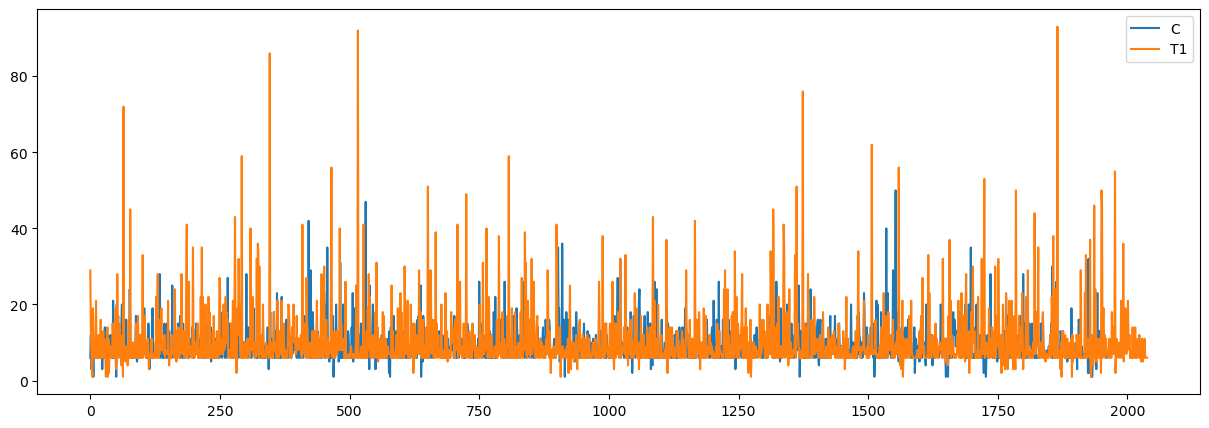

In [112]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass

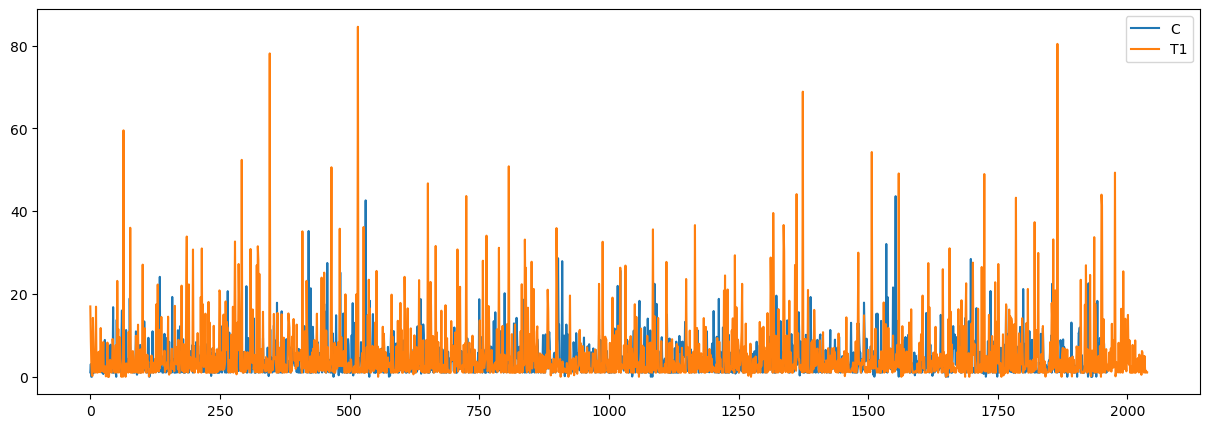

In [113]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass

## Analyze the experiment

In [114]:
user_level_data = (sessions.reset_index().groupby(["user", "treatment"]).agg({
            "timestamp": "count", "tracks": "sum", "time": "sum",
            "latency": "sum"}))

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = ["time", "sessions", "mean_request_latency", "mean_tracks_per_session", "mean_time_per_session"]
user_level_metrics = user_level_data[metrics].copy().reset_index()
treatment_level_metrics = (user_level_metrics.groupby("treatment")[metrics].agg(["count", "mean", "var"]))

def dof(n_0, n_1, s2_0, s2_1):
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)

effects = []
control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]
for treatment, row in treatment_level_metrics.iterrows():
    if treatment == "C":
        continue
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"])
        effects.append({ "treatment": treatment,
            "metric": metric, "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0})

def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'

# 0  Baseline
    The Baseline: C = Contextual, T1 = Contextual
Видно, что случайные флуктуации могут быть в различные стороны

In [107]:
(pd.DataFrame(effects)[["treatment", "metric", "effect", "upper", "lower", "control_mean", 
        "treatment_mean","significant"]].sort_values(["metric", "treatment"], ascending=False).style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"]))

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,-1.231042,9.568368,-12.030453,5.925993,5.853041,False
1,T1,sessions,-2.451328,1.060253,-5.962909,1.197400,1.168047,False
3,T1,mean_tracks_per_session,0.909106,6.096442,-4.278230,9.939716,10.030079,False
4,T1,mean_time_per_session,1.391969,11.594856,-8.810918,4.939927,5.008689,False
2,T1,mean_request_latency,-0.865060,3.850685,-5.580804,0.706163,0.700054,False


# 1 - Ранжирование внутри рекомендаций
    Main Recommender: Contextual on top-50 
    Default: Random
Контекстный рокеммендер на отранжированных рекомендациях (взяты топ 50 треков) с рандомным дефолтным 

In [40]:
(pd.DataFrame(effects)[["treatment", "metric", "effect", "upper", "lower", "control_mean", 
        "treatment_mean","significant"]].sort_values(["metric", "treatment"], ascending=False).style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"]))

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,9.642749,18.512431,0.773068,6.672153,7.315532,True
1,T1,sessions,2.952481,6.792979,-0.888017,1.399142,1.440451,False
3,T1,mean_tracks_per_session,3.020560,6.850576,-0.809456,9.804028,10.100164,False
4,T1,mean_time_per_session,6.300507,13.940584,-1.339570,4.800330,5.102775,False
2,T1,mean_request_latency,467.982121,477.358916,458.605327,1.364175,7.748273,True


# 2 Логирование треков пользователя
    Main Recommender: Contextual on top-50 
    Default: Random 
    Addition: History log
Такой результат был до очистки данных для каждого пользователя 

In [48]:
(pd.DataFrame(effects)[["treatment", "metric", "effect", "upper", "lower", "control_mean", 
        "treatment_mean","significant"]].sort_values(["metric", "treatment"], ascending=False).style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"]))

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,-58.654642,-52.187654,-65.121630,7.484125,3.094338,True
1,T1,sessions,-2.905104,0.886828,-6.697037,1.482930,1.439850,False
3,T1,mean_tracks_per_session,-28.870490,-25.978585,-31.762394,10.045092,7.145025,True
4,T1,mean_time_per_session,-57.567907,-51.989859,-63.145955,5.050969,2.143232,True
2,T1,mean_request_latency,531.738787,544.354292,519.123283,1.173819,7.415468,True


    Main Recommender: Contextual on top-50 
    Default: Random 
    Addition: History log, clean of data
Видим, что логирование и очистка истории уже позволяет нам побить обычный Contextual рекоммендер со значимым отрывом

In [70]:
(pd.DataFrame(effects)[["treatment", "metric", "effect", "upper", "lower", "control_mean", 
        "treatment_mean","significant"]].sort_values(["metric", "treatment"], ascending=False).style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"]))

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,19.190330,29.808891,8.571770,7.288995,8.687777,True
1,T1,sessions,-0.841799,2.955868,-4.639465,1.427199,1.415185,False
3,T1,mean_tracks_per_session,9.588260,14.209242,4.967278,10.017911,10.978454,True
4,T1,mean_time_per_session,19.249449,28.288504,10.210394,5.019989,5.986309,True
2,T1,mean_request_latency,489.021092,498.691159,479.351024,1.059396,6.240066,True


    Main Recommender: Contextual on top-30 
    Default: Random 
    Addition: History log, clean of data
Проверим, сокращение топа c 50 до 30 повлияет на результат или нет

In [78]:
(pd.DataFrame(effects)[["treatment", "metric", "effect", "upper", "lower", "control_mean", 
        "treatment_mean","significant"]].sort_values(["metric", "treatment"], ascending=False).style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"]))

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,17.355510,27.476351,7.234669,6.957521,8.165035,True
1,T1,sessions,-0.523238,3.269459,-4.315935,1.406250,1.398892,False
3,T1,mean_tracks_per_session,9.550668,14.238070,4.863266,9.970964,10.923257,True
4,T1,mean_time_per_session,18.808132,28.022610,9.593655,4.988084,5.926249,True
2,T1,mean_request_latency,470.188264,479.569642,460.806885,1.184978,6.756608,True


# 3 Дефолтный рекоммендер
    Main Recommender: Contextual on top-50 
    Default: Indexed 
    Addition: History log, clean of logs
Дает небольшой профит + 3%

In [86]:
(pd.DataFrame(effects)[["treatment", "metric", "effect", "upper", "lower", "control_mean", 
        "treatment_mean","significant"]].sort_values(["metric", "treatment"], ascending=False).style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"]))

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,21.604402,32.409518,10.799287,6.965455,8.470299,True
1,T1,sessions,0.234228,3.980508,-3.512052,1.415786,1.419102,False
3,T1,mean_tracks_per_session,10.446591,15.038096,5.855086,9.844726,10.873165,True
4,T1,mean_time_per_session,21.606171,30.787950,12.424391,4.828855,5.872186,True
2,T1,mean_request_latency,478.294619,488.337384,468.251853,1.129061,6.529298,True


# 4 Получение большей выборки рекомендаций
    Main Recommender: Contextual on top-50 
    Default: Indexed 
    Addition: History log, clean of logs
    Data: more recomendations (k = 200) with the same model 
Профит + 8%

In [94]:
(pd.DataFrame(effects)[["treatment", "metric", "effect", "upper", "lower", "control_mean", 
        "treatment_mean","significant"]].sort_values(["metric", "treatment"], ascending=False).style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"]))

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,30.575966,41.926579,19.225352,5.776405,7.542597,True
1,T1,sessions,0.439437,4.235956,-3.357081,1.409777,1.415972,False
3,T1,mean_tracks_per_session,12.904025,17.538003,8.270048,9.116139,10.292488,True
4,T1,mean_time_per_session,28.389260,38.425552,18.352968,4.119239,5.288660,True
2,T1,mean_request_latency,415.363481,424.407277,406.319685,1.255747,6.471660,True


В заключение могу отметить, что в текущем моменте понятно как минимум то, что некоторые эксперименты надо было проводить в обратном порядке и немного иначе сравнивать эффект моделей. Например, все эксперименты можно было начать с получения большего числа рекомендаций, тогда эффект от изменения дефолтного рекоммендера, возможно, был бы заметнее или понятнее. Также стоило продумать удобство тестирования гипотез и составления отчета из большого числа экспериментов